In [1]:
from corgisim import scene
from corgisim import instrument
from corgisim import spec
import matplotlib.pyplot as plt
import numpy as np
import proper
import roman_preflight_proper

In [2]:
import scipy.interpolate

In [3]:
cgi_mode = 'spec'
cor_type = 'spc-spec_band3'
bandpass = '3F'
cases = ['2e-8']      
# cases = ['1e-9']      
rootname = 'spc-spec_ni_' + cases[0]
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )

In [4]:
##  Define the polaxis parameter. Use 10 for non-polaxis cases only, as other options are not yet implemented.
polaxis = 10
# output_dim define the size of the output image
output_dim = 121
overfac = 5

mas_per_lamD = 63.72 # Band 3
source_y_offset = 6.0 #lam/D
source_y_offset_mas = source_y_offset * mas_per_lamD

#set slit keyword to R1C2
#supported slits in band 2 are R6C5 and R3C1
#supported slits in band 3 are R1C2 and R3C1
offset_star_optics_keywords ={'cor_type':cor_type, 'use_errors':0, 'polaxis':polaxis, 'output_dim':output_dim, 
        'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2, 'use_fpm':0, 'use_lyot_stop':1, 'fsm_y_offset':source_y_offset,
        'prism':'PRISM3', 'wav_step_um':2E-3, 'slit':'R1C2', 'slit_y_offset_mas':source_y_offset_mas} 

optics = instrument.CorgiOptics(cgi_mode, bandpass='3F', optics_keywords=offset_star_optics_keywords, if_quiet=True,
                                oversample = overfac, return_oversample = False)

CorgiOptics initialized with proper keywords.


In [5]:
# def get_slit_mask(optics, dx_fsam_um=10.0, hires_dim_um=800, binfac=50):
dx_fsam_um = 10.0
hires_dim_um = 800
binfac = 50

"""Generate an FSAM slit mask array for spec mode simulations.

This function creates a high-resolution slit mask based on the specified aperture
parameters and then bins it down to an intermediate spatial resolution.
The function handles slit positioning offsets,
and proper scaling based on the coronagraph configuration.

Args:
    optics (object): CorgiOptics configuration object containing:
        - cor_type (str): Coronagraph type ('spc-spec_band3' or other)
        - lamref_um (float): Reference wavelength of mode in micrometers
        - ref_data_dir (str): Directory path containing reference data files
        - slit (str): Name of the slit to use
        - slit_x_offset_mas (float or None): Slit offset in x-direction in milliarcseconds
        - slit_y_offset_mas (float or None): Slit offset in y-direction in milliarcseconds
    dx_fsam_um (float, optional): FSAM slit array spatial sampling in micrometers. Defaults to 10.0.
    hires_dim_um (float, optional): High-resolution array dimension in micrometers. Defaults to 800.
    binfac (int, optional): Binning factor for downsampling. Defaults to 50.
Returns:
    tuple:
        - numpy.ndarray: 2D array representing the FSAM slit transmision, with values between 0 and 1
        - float: Spatial sampling of FSAM slit array in meters

Raises:
    Exception: If the requested slit is not defined in the reference parameter file
    ValueError: If the binning factor does not evenly divide the image dimensions

Notes:
    - Uses Roman Space Telescope preflight proper model parameters for scaling
    - Slit parameters are loaded from 'FSAM_slit_params.json' reference file
    - The function applies user-specified offsets

Example:
    >>> binned_mask, pixel_size = get_slit_mask(self, binfac=25)
    >>> print(f"Binned mask shape: {binned_mask.shape}")
"""
if not hires_dim_um % dx_fsam_um == 0:
    raise ValueError(f"The spatial dimension of the binned FSAM array, hires_dim_um={hires_dim_um} microns, is not a whole number ratio to the binned spatial sampling scale, dx_fsam_um={dx_fsam_um} microns.")

# Set the scale factor between physical length and diffraction model units (lambda/D) at the FSAM
# These scale parameters are listed in the Roman Preflight Proper model manual
if optics.optics_keywords['cor_type'] == 'spc-spec_band2':
    fsam_meter_per_lamD = 1.34273E-5 / (1000 / 2048) # Roman Preflight PROPER Prescription manual, v2.0, pg 19
else:
    fsam_meter_per_lamD = 1.48513E-5 / (1000 / 2048) # Roman Preflight PROPER Prescription manual, v2.0, pg 19
# Set the scale factor between angle on sky (milliarcseconds) and diffraction model units (lambda/D)
# See Roman Preflight PROPER Prescription manual, v2.0, pg 18
mas_per_lamD = optics.lamref_um * 1E-6 * 360.0 * 3600.0 / (2 * np.pi * 2.363) * 1000 
fsam_meter_per_mas = fsam_meter_per_lamD / mas_per_lamD

# Read the slit aperture width and height for the named FSAM position
slit_ref_params = spec.read_slit_params(optics.slit_param_fname)
if optics.slit not in slit_ref_params.keys():
    raise Exception('ERROR: Requested slit {:s} is not defined in {:s}'.format(optics.slit, optics.slit_param_fname))
# The offset of the slit with respect to the star is zero unless specified
if optics.slit_x_offset_mas == None:
    optics.slit_x_offset_mas = 0 
if optics.slit_y_offset_mas == None:
    optics.slit_y_offset_mas = 0
# Convert the offset to relative FSAM position. Note that CGISim does not model the as-built FSAM, so this is idealized.
# When planning spectroscopy observations, the observer should use a calibrated coordinate transformation 
# to determine the FSAM position for a given source offset.
(slit_x_offset_um, slit_y_offset_um) = (1E6 * fsam_meter_per_mas * optics.slit_x_offset_mas,
                                        1E6 * fsam_meter_per_mas * optics.slit_y_offset_mas) 

dx_hires_um = dx_fsam_um / binfac # spatial sampling of binned FSAM slit transmission array in microns
dx_fsam_m = dx_fsam_um * 1E-6 # same as above, in units of meters
# Determine the dimensions of the high-resolution model for the FSAM transmission array 
hires_dimx, hires_dimy = (int(hires_dim_um / dx_hires_um), int(hires_dim_um / dx_hires_um))
# Determine the center coordinates of the high-res array
if hires_dimx % 2 == 0:
    xc = hires_dimx // 2 - 0.5 + slit_x_offset_um / dx_hires_um
    yc = hires_dimy // 2 - 0.5 + slit_y_offset_um / dx_hires_um
else:
    xc = hires_dimx // 2 + slit_x_offset_um / dx_hires_um
    yc = hires_dimy // 2 + slit_y_offset_um / dx_hires_um
# Make grids for the high-res array coordinates
xs = np.arange(hires_dimx) - xc
ys = np.arange(hires_dimy) - yc
XXs, YYs = np.meshgrid(xs, ys)
# Compute the slit width and height in high-res array coordinates
slit_width_hires = 1.0 / dx_hires_um * slit_ref_params[optics.slit]['width'] 
slit_height_hires = 1.0 / dx_hires_um * slit_ref_params[optics.slit]['height']
# Determine the binary, high-res transmission array
hires_slit = ((np.abs(XXs) < slit_height_hires / 2) & 
                (np.abs(YYs) < slit_width_hires / 2))
# Bin the high-res array to the specified spatial sampling
binned_slit = hires_slit.reshape(hires_dimy // binfac, binfac, 
                                    hires_dimx // binfac, binfac).mean(axis=3).mean(axis=1)
# Rotate and flip the slit array to match the orientation as applied in the PROPER model
rot_binned_slit = np.fliplr(np.rot90(binned_slit, 3))
# return rot_binned_slit, dx_fsam_m

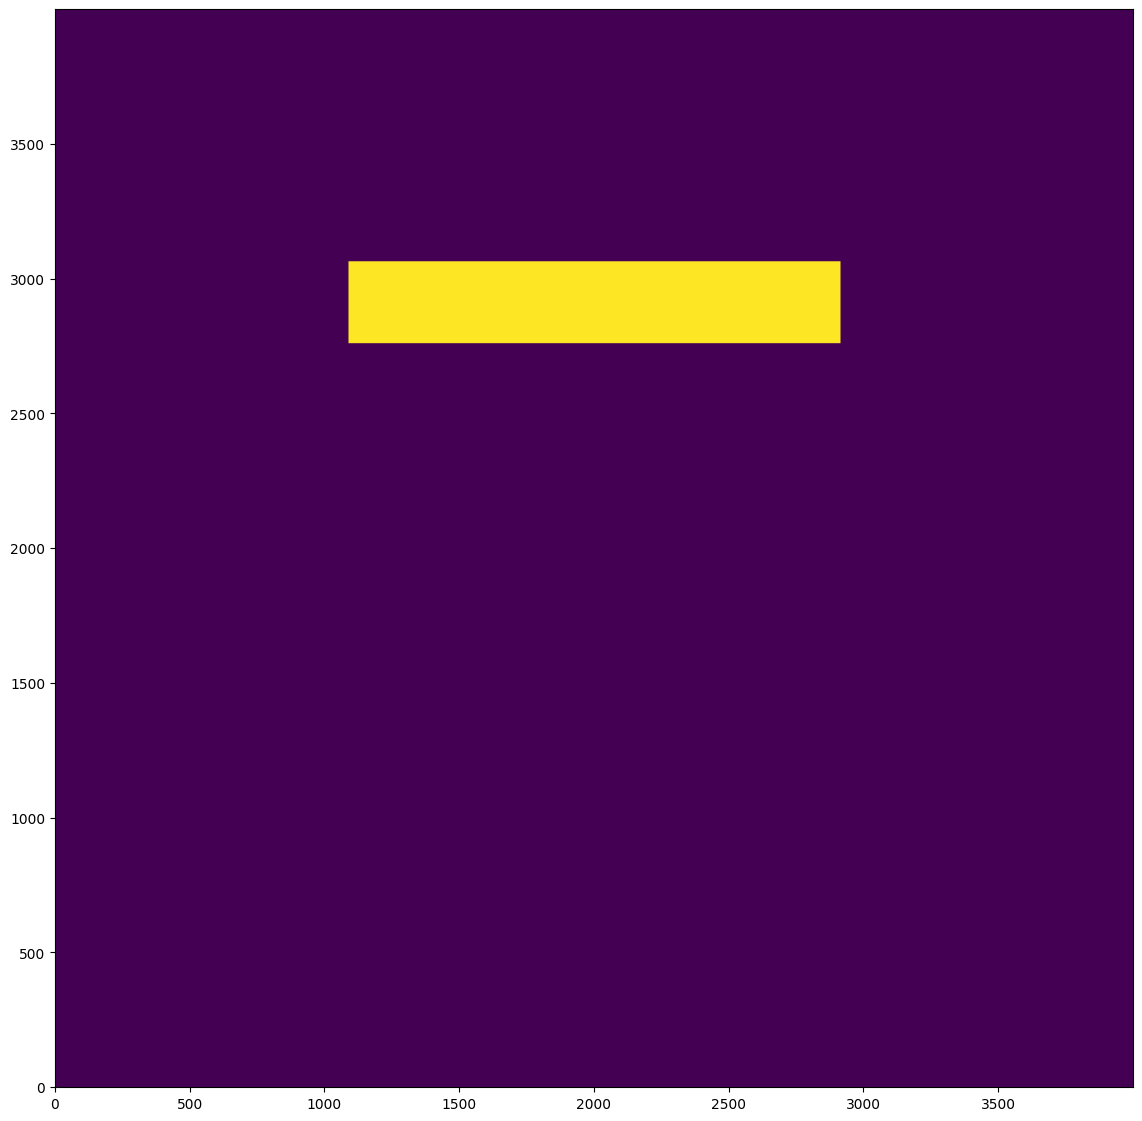

In [6]:
plt.figure(figsize=(16,14))
# plt.imshow(binned_slit, origin='lower')
plt.imshow(hires_slit, origin='lower')

### Test R2C2 rotated slit

In [32]:
source_x_offset = 9.0 #lam/D
source_x_offset_mas = source_x_offset * mas_per_lamD

offset_star_optics_keywords ={'cor_type':cor_type, 'use_errors':0, 'polaxis':polaxis, 'output_dim':output_dim, 
        'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2, 'use_fpm':0, 'use_lyot_stop':1, 'fsm_x_offset':source_x_offset,
        'prism':'PRISM3', 'wav_step_um':2E-3, 'slit':'R2C2', 'slit_x_offset_mas':source_x_offset_mas} 

optics = instrument.CorgiOptics(cgi_mode, bandpass='3F', optics_keywords=offset_star_optics_keywords, if_quiet=True,
                                oversample = overfac, return_oversample = False)

CorgiOptics initialized with proper keywords.


In [33]:
# def get_slit_mask(optics, dx_fsam_um=10.0, hires_dim_um=800, binfac=50):
dx_fsam_um = 10.0
hires_dim_um = 800
binfac = 50

"""Generate an FSAM slit mask array for spec mode simulations.

This function creates a high-resolution slit mask based on the specified aperture
parameters and then bins it down to an intermediate spatial resolution.
The function handles slit positioning offsets,
and proper scaling based on the coronagraph configuration.

Args:
    optics (object): CorgiOptics configuration object containing:
        - cor_type (str): Coronagraph type ('spc-spec_band3' or other)
        - lamref_um (float): Reference wavelength of mode in micrometers
        - ref_data_dir (str): Directory path containing reference data files
        - slit (str): Name of the slit to use
        - slit_x_offset_mas (float or None): Slit offset in x-direction in milliarcseconds
        - slit_y_offset_mas (float or None): Slit offset in y-direction in milliarcseconds
    dx_fsam_um (float, optional): FSAM slit array spatial sampling in micrometers. Defaults to 10.0.
    hires_dim_um (float, optional): High-resolution array dimension in micrometers. Defaults to 800.
    binfac (int, optional): Binning factor for downsampling. Defaults to 50.
Returns:
    tuple:
        - numpy.ndarray: 2D array representing the FSAM slit transmision, with values between 0 and 1
        - float: Spatial sampling of FSAM slit array in meters

Raises:
    Exception: If the requested slit is not defined in the reference parameter file
    ValueError: If the binning factor does not evenly divide the image dimensions

Notes:
    - Uses Roman Space Telescope preflight proper model parameters for scaling
    - Slit parameters are loaded from 'FSAM_slit_params.json' reference file
    - The function applies user-specified offsets

Example:
    >>> binned_mask, pixel_size = get_slit_mask(self, binfac=25)
    >>> print(f"Binned mask shape: {binned_mask.shape}")
"""
if not hires_dim_um % dx_fsam_um == 0:
    raise ValueError(f"The spatial dimension of the binned FSAM array, hires_dim_um={hires_dim_um} microns, is not a whole number ratio to the binned spatial sampling scale, dx_fsam_um={dx_fsam_um} microns.")

# Set the scale factor between physical length and diffraction model units (lambda/D) at the FSAM
# These scale parameters are listed in the Roman Preflight Proper model manual
if optics.optics_keywords['cor_type'] == 'spc-spec_band2':
    fsam_meter_per_lamD = 1.34273E-5 / (1000 / 2048) # Roman Preflight PROPER Prescription manual, v2.0, pg 19
else:
    fsam_meter_per_lamD = 1.48513E-5 / (1000 / 2048) # Roman Preflight PROPER Prescription manual, v2.0, pg 19
# Set the scale factor between angle on sky (milliarcseconds) and diffraction model units (lambda/D)
# See Roman Preflight PROPER Prescription manual, v2.0, pg 18
mas_per_lamD = optics.lamref_um * 1E-6 * 360.0 * 3600.0 / (2 * np.pi * 2.363) * 1000 
fsam_meter_per_mas = fsam_meter_per_lamD / mas_per_lamD

# Read the slit aperture width and height for the named FSAM position
slit_ref_params = spec.read_slit_params(optics.slit_param_fname)
if optics.slit not in slit_ref_params.keys():
    raise Exception('ERROR: Requested slit {:s} is not defined in {:s}'.format(optics.slit, optics.slit_param_fname))
# The offset of the slit with respect to the star is zero unless specified
if optics.slit_x_offset_mas == None:
    optics.slit_x_offset_mas = 0 
if optics.slit_y_offset_mas == None:
    optics.slit_y_offset_mas = 0
# Convert the offset to relative FSAM position. Note that CGISim does not model the as-built FSAM, so this is idealized.
# When planning spectroscopy observations, the observer should use a calibrated coordinate transformation 
# to determine the FSAM position for a given source offset.
(slit_x_offset_um, slit_y_offset_um) = (1E6 * fsam_meter_per_mas * optics.slit_x_offset_mas,
                                        1E6 * fsam_meter_per_mas * optics.slit_y_offset_mas) 

dx_hires_um = dx_fsam_um / binfac # spatial sampling of binned FSAM slit transmission array in microns
dx_fsam_m = dx_fsam_um * 1E-6 # same as above, in units of meters
# Determine the dimensions of the high-resolution model for the FSAM transmission array 
hires_dimx, hires_dimy = (int(hires_dim_um / dx_hires_um), int(hires_dim_um / dx_hires_um))
# Determine the center coordinates of the high-res array
if hires_dimx % 2 == 0:
    xc = hires_dimx // 2 - 0.5 + slit_x_offset_um / dx_hires_um
    yc = hires_dimy // 2 - 0.5 + slit_y_offset_um / dx_hires_um
else:
    xc = hires_dimx // 2 + slit_x_offset_um / dx_hires_um
    yc = hires_dimy // 2 + slit_y_offset_um / dx_hires_um
# Make grids for the high-res array coordinates
xs = np.arange(hires_dimx) - xc
ys = np.arange(hires_dimy) - yc
XXs, YYs = np.meshgrid(xs, ys)
# Compute the slit width and height in high-res array coordinates
slit_width_hires = 1.0 / dx_hires_um * slit_ref_params[optics.slit]['width'] 
slit_height_hires = 1.0 / dx_hires_um * slit_ref_params[optics.slit]['height']
# Determine the binary, high-res transmission array
if 'rotation' in slit_ref_params[optics.slit].keys():
    theta = np.deg2rad(slit_ref_params[optics.slit]['rotation'])
    hires_slit = ((YYs < XXs / np.tan(theta) + slit_width_hires / (2 * np.sin(theta))) &
                  (YYs > XXs / np.tan(theta) - slit_width_hires / (2 * np.sin(theta))) &
                  (YYs < -XXs * np.tan(theta) + slit_height_hires / (2 * np.cos(theta))) &
                  (YYs > -XXs * np.tan(theta) - slit_height_hires / (2 * np.cos(theta)))) 
else:
    hires_slit = ((np.abs(XXs) < slit_height_hires / 2) & 
                  (np.abs(YYs) < slit_width_hires / 2))
# Bin the high-res array to the specified spatial sampling
binned_slit = hires_slit.reshape(hires_dimy // binfac, binfac, 
                                 hires_dimx // binfac, binfac).mean(axis=3).mean(axis=1)
# Rotate and flip the slit array to match the orientation as applied in the PROPER model
rot_binned_slit = np.fliplr(np.rot90(binned_slit, 3))
# return rot_binned_slit, dx_fsam_m

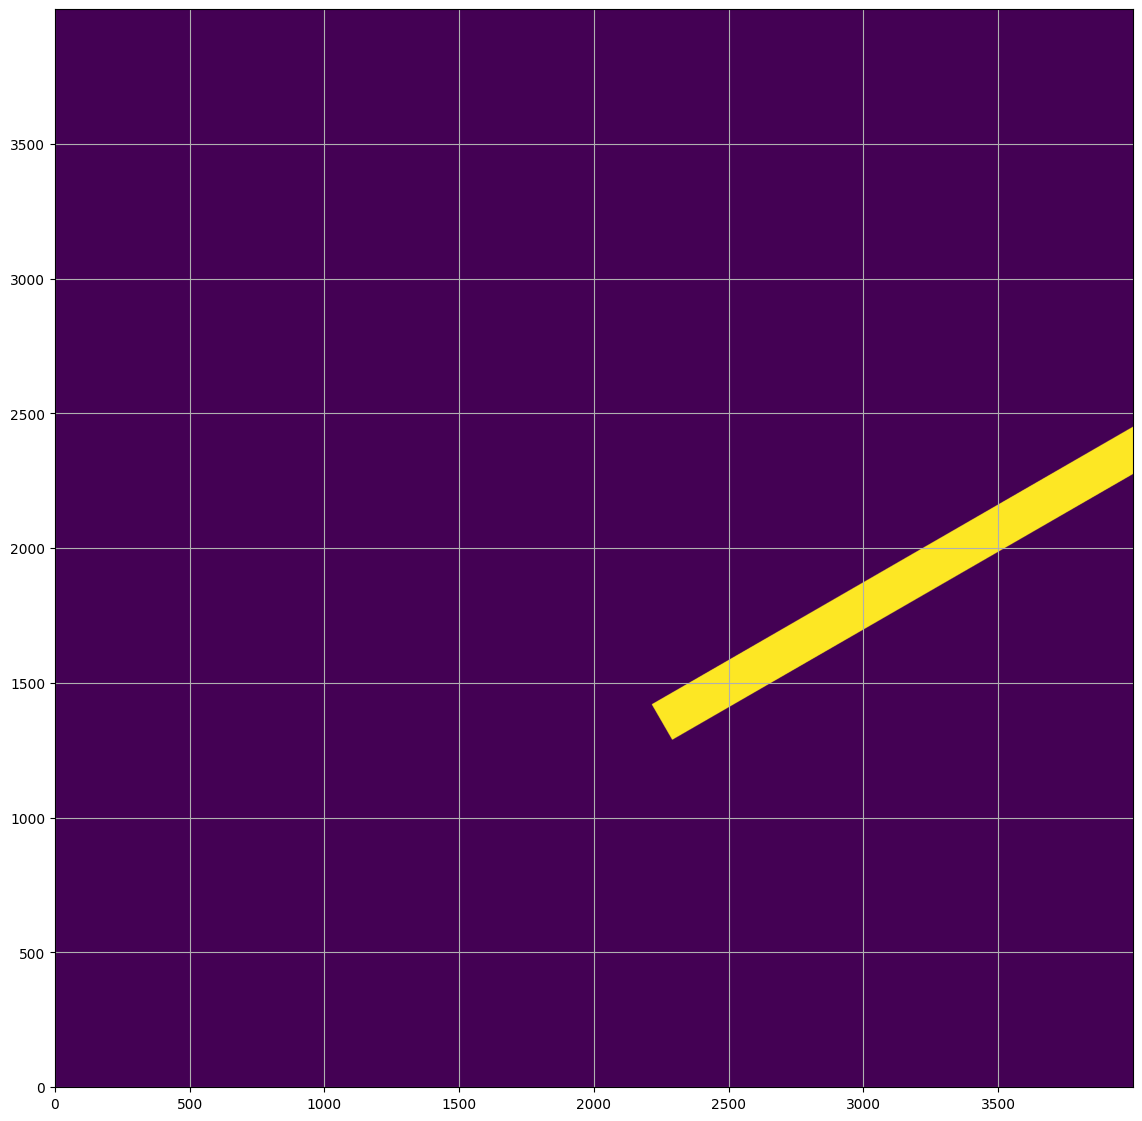

In [34]:
plt.figure(figsize=(16,14))
# plt.imshow(binned_slit, origin='lower')
plt.imshow(hires_slit, origin='lower')
plt.grid(True)